In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import nltk
from konlpy.tag import Okt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans as km

import hdbscan
from sklearn.cluster import DBSCAN


# 한글 폰트 설정
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')
else:
    print('Unknown system... sorry~')

### Stemming & tokenizing & Word2vec

In [2]:
path = "../../datas/"
stopwords = ['',' ', '지다', ' ', '아', '나', '정', '다','좀', '있다', '조금', '요', '되어다', '더', '너', '친', '가자', '아주', '그렇다', '바라','싶다','습니다','좀',
             '및', '...', '도', '수', '나다', '엄청', '것', '점', '등', '사', '에', '옆','이다','보다', '되다', '항상', '어요']
data = pd.read_csv(path+"v5_category_re_token_sum.csv")
reviews = data['highlight_review']

new_list = []
for r in range(len(data)):
    try: 
        rv = reviews.iloc[r]
        rv = rv.split(" ")
        rv.append(data['category'].iloc[r])
        rv = [re.compile('[^가-힣]+').sub("", r) for r in rv]
        rv = [re.compile('[은, 는, 이, 도, 의]+').sub("", r) for r in rv]
        rv = [r.replace(r, "") if len(r)<1 or r in stopwords else r for r in rv]
        new_list.append(rv)

    except:
        new_list.append("")

# vocabs = [word for word in new_list if word not in stopwords and len(word)>1]
print("total words num: ", len(new_list))
data['cat_plus_rv'] = new_list
reviews = data['cat_plus_rv']
model = Word2Vec(reviews, sg=1, # skinp-gram: 중심단어로 주변단어 예측
                 vector_size=2,
                 workers=6, 
                 window=5,      # 중심 단어로부터 좌우 n개까지 학습에 적용
                 min_count=100, # 전체 문서에서 최소 n회 이상 출현 단어로 학습
                 sample=0.001
                ) 

word_vectors = model.wv.vectors

vocabs = list(model.wv.index_to_key)
word_vectors_list = [model.wv[v] for v in vocabs]

print(len(word_vectors), len(vocabs), vocabs)

total words num:  120997
366 366 ['좋다', '메인시설', '서비스', '', '친절하다', '만족', '사장님', '너무', '깨끗하다', '분위기', '시설', '청결', '부대공용시설', '전망', '위치', '화장실', '수영장', '자다', '깔끔하다', '정말', '많다', '가격', '계곡', '만족하다', '하다', '직원분', '없다', '뷰', '샤워실', '개수대', '넘다', '가깝다', '모두', '샤워장', '경치', '넓다', '오다', '괜찮다', '아쉽다', '조용하다', '방', '음식조식', '매우', '비품', '따뜻하다', '가다', '관리', '편하다', '친절', '너무좋다', '않다', '만족스럽다', '관리가', '글램핑', '뷰가', '캠핑장', '풍경', '또', '주변', '너무너무', '불편하다', '진짜', '내부', '놀다', '잘되어다', '편시설', '벌레', '사장님께서', '예쁘다', '사트', '주인분', '청결하다', '물', '같다', '온수', '최고다', '카라반', '고', '쁘다', '쉬다', '나무', '많', '바베큐', '벌레가', '최고', '매점', '바로', '좋아하다', '생각보다', '완전', '나오다', '분위기가', '크다', '멀다', '안되다', '경치가', '다음에', '분', '바다', '맛있다', '너무친절하다', '예약', '잘되다', '사모님', '직원', '저렴하다', '시원하다', '숙소', '잘나오다', '샤워시설', '차다', '용하다', '깨끗', '내외분', '경치좋다', '매너타임', '난방', '불', '즐겁다', '시설깨끗하다', '부대시설', '바닥', '힘다', '좁다', '사장님친절하다', '맘에', '앞에', '물놀', '화장실과', '작다', '굉장하다', '굿', '간격', '해주다', '가성비', '마음에', '가격대비', '보내다', '서다', '공기', '전체적으로', '부족하다', '재밌다', '

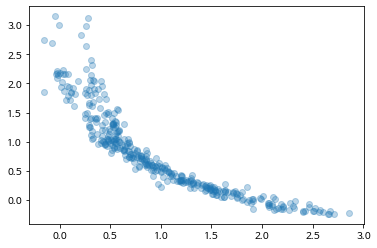

In [3]:
plt.scatter(word_vectors.T[0], word_vectors.T[1], alpha=0.3)
plt.show()

### 차원축소를 하지 않으면 전혀 군집이 되지 않음

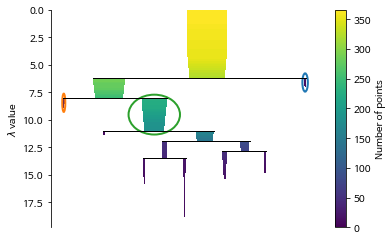

In [4]:
import hdbscan
from sklearn.cluster import DBSCAN

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, gen_min_span_tree=True)
clusterer.fit(word_vectors)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [5]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(word_vectors)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(word_vectors)

# 데이터 프레임 만들기
df = pd.DataFrame(word_vectors)
df["labels"] = pred_hds
df.index = vocabs

print(np.unique(df["labels"]))
df.tail(2)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]


,0,1,labels
글램핑다,0.764229,0.843849,-1
냉장고,1.575677,0.161087,7


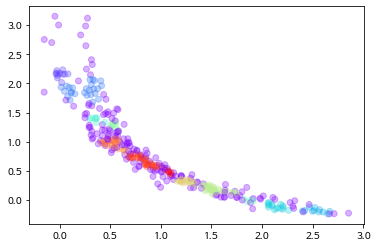

In [6]:
plt.scatter(df[0], df[1], c=df["labels"], cmap="rainbow", alpha=0.3)
plt.show()

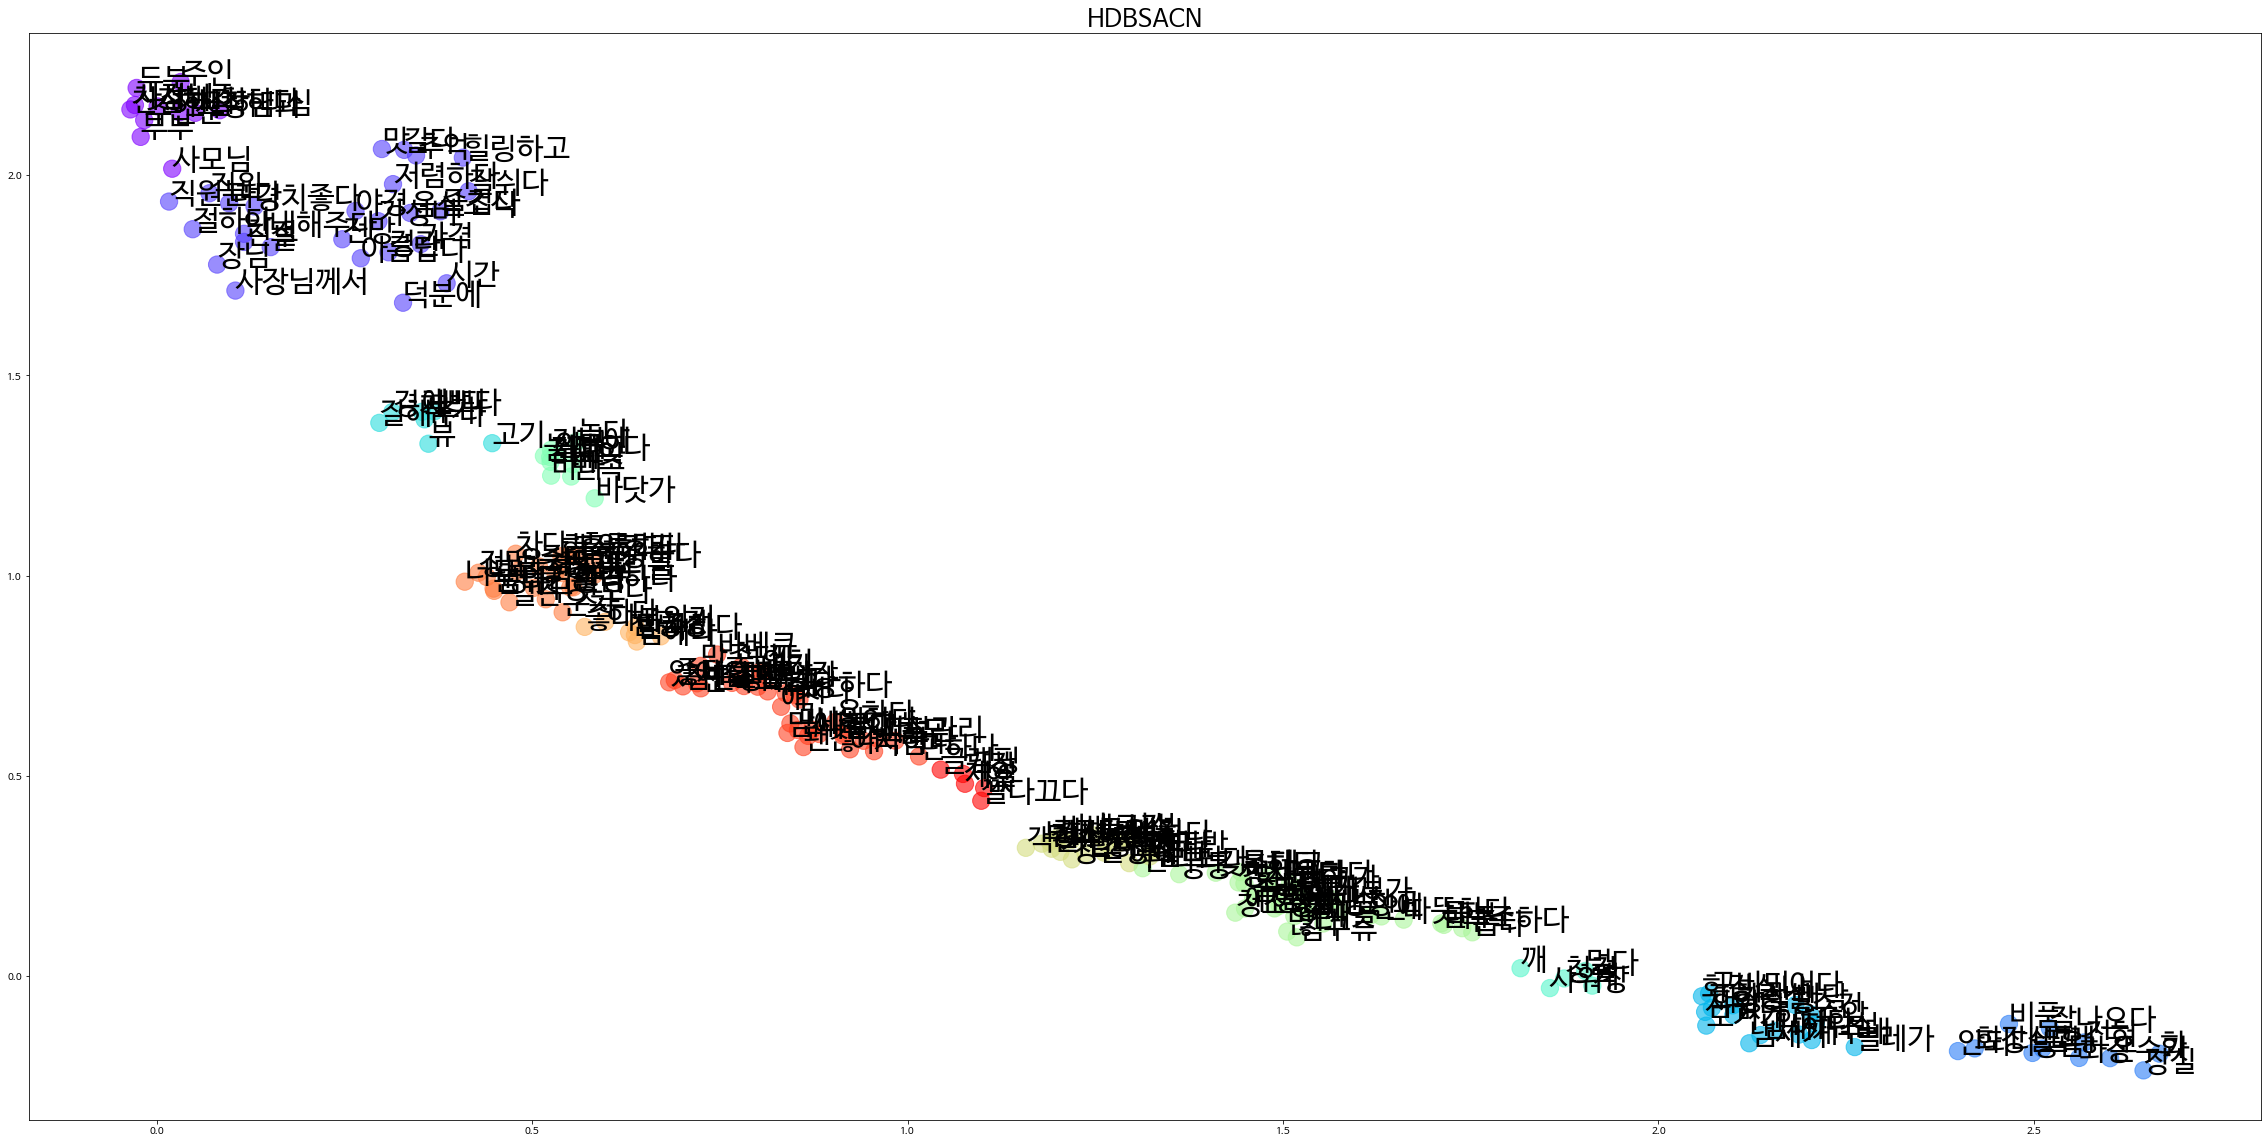

In [7]:
plt.figure(figsize=(40, 20))
plt.title("HDBSACN", fontsize= 25)
df.drop(df[df['labels']== -1].index,inplace=True)
plt.scatter(df[0], df[1], c= df["labels"], s=300, cmap="rainbow", alpha=0.6)

for i, v in enumerate(df.index):
    plt.annotate(v, xy=(df[0][i], df[1][i]), fontsize=30)

plt.show()

In [17]:
for idx in np.unique(df["labels"]):
    print(f"Group{idx}\n",df[df["labels"]==idx].index.tolist())

Group0
 ['서비스', '친절하다', '사장님', '주인분', '사모님', '주인', '사장님과', '착하다', '부부', '두분', '친절하다심']
Group1
 ['전망', '가격', '직원분', '음식조식', '친절', '사장님께서', '분', '직원', '저렴하다', '경치좋다', '즐겁다', '가성비', '시간', '경관', '힐링하고', '갈다', '잘쉬다', '아름답다', '맛', '추억', '덕분에', '절하다', '장님', '다다', '야경', '안내해주다']
Group2
 ['비품', '벌레', '안되다', '잘나오다', '화장실과', '온수가', '방음', '화', '화장', '전혀', '장실']
Group3
 ['화장실', '없다', '샤워실', '개수대', '벌레가', '바닥', '냄새', '냄새가', '모기가', '수압', '샤워', '화장실랑', '약하다', '화장실나', '구비되어다', '수건']
Group4
 ['뷰', '경치', '뷰가', '예쁘다', '쁘다', '잘해주다', '고기']
Group5
 ['청결', '샤워장', '멀다', '깨', '개']
Group6
 ['만족', '가다', '놀다', '바다', '예약', '놀다오다', '앞라', '바닷가', '저녁에', '보고']
Group7
 ['많다', '넓다', '방', '따뜻하다', '않다', '내부', '물', '많', '생각보다', '깨끗', '불', '좁다', '작다', '부족하다', '에어컨', '데크', '놀거리', '실내', '갖추다', '안', '놀거리가', '텐트', '침구류', '내부가', '안에', '등등', '관리되다', '공용시설', '사용하다', '상태', '못하다', '데크가', '청소상태', '냉장고']
Group8
 ['가깝다', '아쉽다', '청결하다', '카라반', '매점', '크다', '부대시설', '편리하다', '청소', '편', '커서', '용', '장', '놀시설', '청결상태', '넉넉하다', '객실', '바베큐장']
Gro

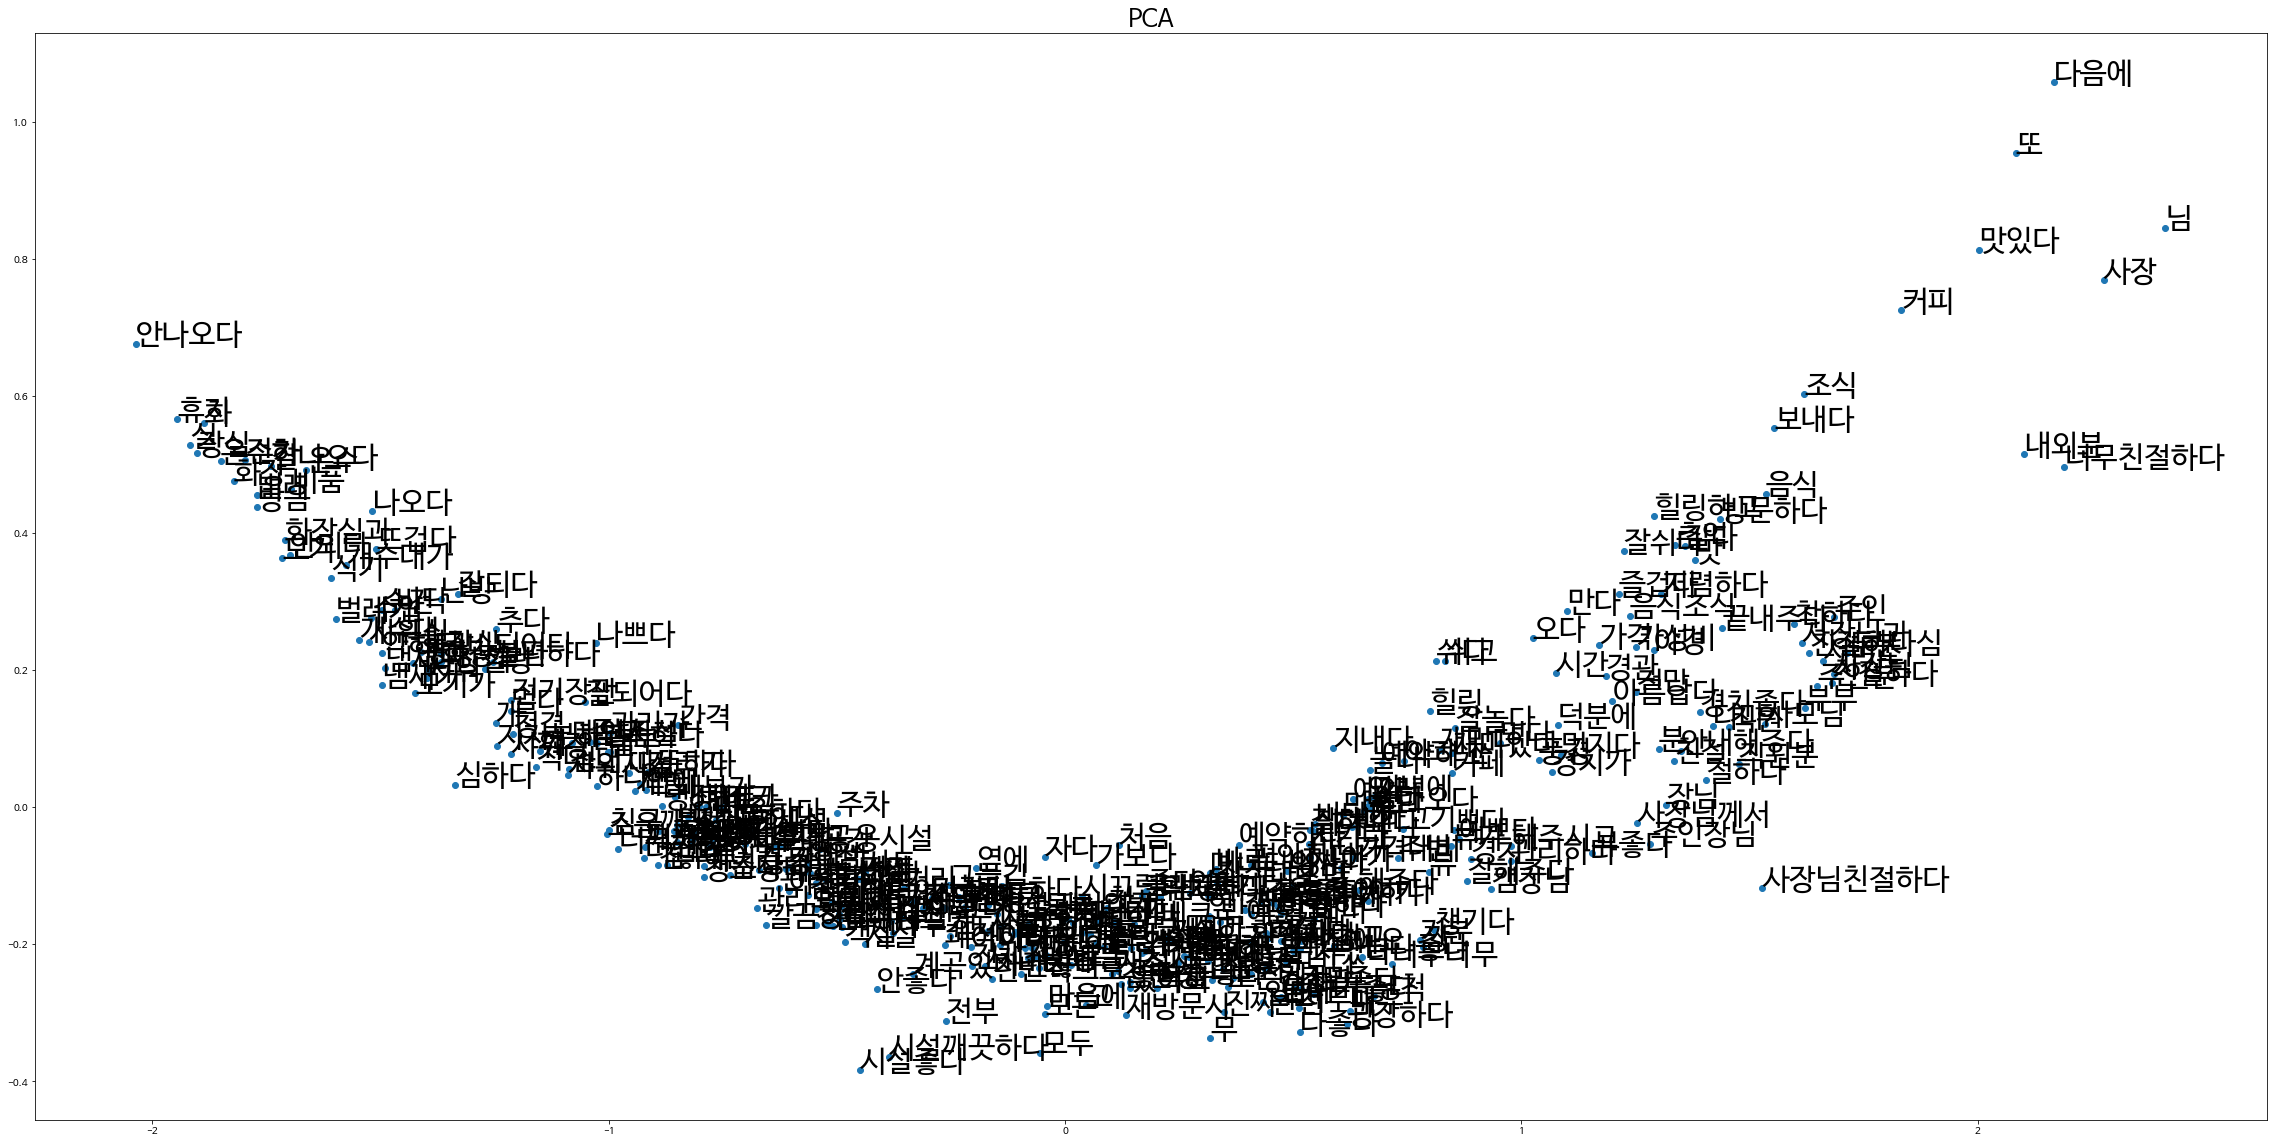

In [18]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(word_vectors)
pca_df = pd.DataFrame(pca_fit, index=vocabs, columns=['x', 'y'])

plt.figure(figsize=(40, 20))
plt.title("PCA", fontsize= 25)
plt.scatter(pca_df["x"], pca_df["y"])

for word, pos in pca_df.iterrows():
    plt.annotate(word, pos, fontsize=30)
plt.show()

#xys = pca.fit_transform(word_vectors)
# xs = xys[:, 0]
# ys = xys[:, 1]

# plt.figure(figsize=(40, 20))
# plt.title("PCA clustering")
# plt.scatter(xs, ys)
# for i, v in enumerate(vocabs):
#     plt.annotate(v, xy=(xs[i], ys[i]), fontsize=30)
# plt.show()

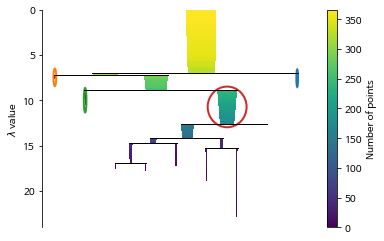

In [19]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(pca_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [20]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=5).fit(pca_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(pca_df)

# 데이터 프레임 만들기
df2 = pd.DataFrame(pca_df)
df2["labels"] = pred_hds

print(np.unique(df2["labels"]), len(df2))
df2.tail(2)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12] 366


,x,y,labels
글램핑다,0.168560,-0.129313,-1
냉장고,-0.883781,0.001792,7


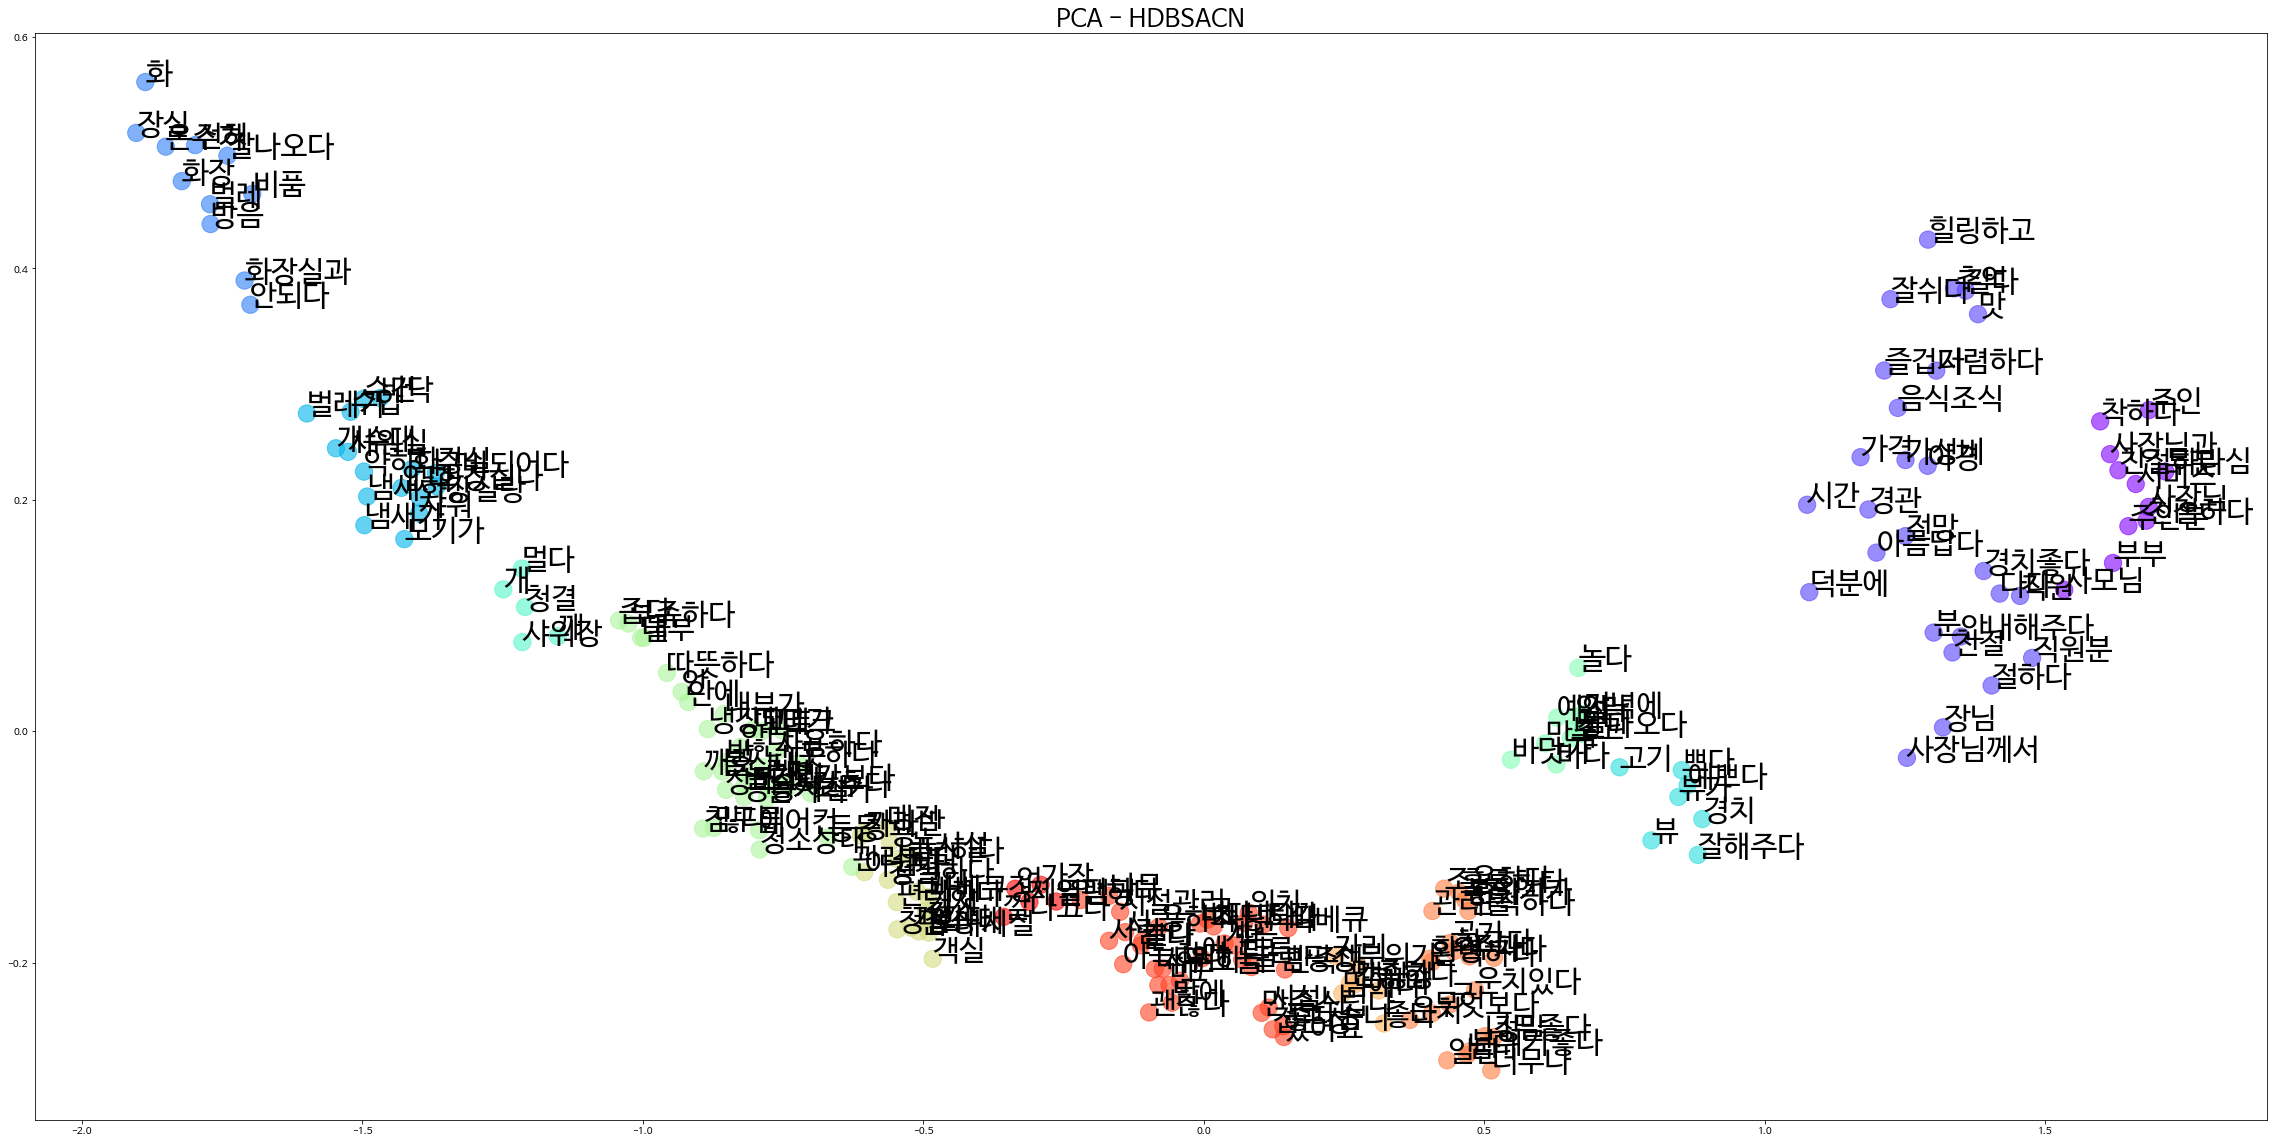

In [21]:
plt.figure(figsize=(40, 20))
plt.title("PCA - HDBSACN", fontsize= 25)
df2.drop(df2[df2['labels']== -1].index,inplace=True)
plt.scatter(df2["x"], df2["y"], c= df2["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df2.index):
    plt.annotate(v, xy=(df2["x"][i], df2["y"][i]), fontsize=30)

plt.show()

In [22]:
for idx in np.unique(df2["labels"]):
    print(f"Group{idx}\n",df2[df2["labels"]==idx].index.tolist())

Group0
 ['서비스', '친절하다', '사장님', '주인분', '사모님', '주인', '사장님과', '착하다', '부부', '두분', '친절하다심']
Group1
 ['전망', '가격', '직원분', '음식조식', '친절', '사장님께서', '분', '직원', '저렴하다', '경치좋다', '즐겁다', '가성비', '시간', '경관', '힐링하고', '갈다', '잘쉬다', '아름답다', '맛', '추억', '덕분에', '절하다', '장님', '다다', '야경', '안내해주다']
Group2
 ['비품', '벌레', '안되다', '잘나오다', '화장실과', '온수가', '방음', '화', '화장', '전혀', '장실']
Group3
 ['화장실', '없다', '샤워실', '개수대', '벌레가', '바닥', '냄새', '냄새가', '모기가', '수압', '샤워', '화장실랑', '약하다', '화장실나', '구비되어다', '수건']
Group4
 ['뷰', '경치', '뷰가', '예쁘다', '쁘다', '잘해주다', '고기']
Group5
 ['청결', '샤워장', '멀다', '깨', '개']
Group6
 ['만족', '가다', '놀다', '바다', '예약', '놀다오다', '앞라', '바닷가', '저녁에', '보고']
Group7
 ['많다', '넓다', '방', '따뜻하다', '않다', '내부', '물', '많', '생각보다', '깨끗', '불', '좁다', '작다', '부족하다', '에어컨', '데크', '놀거리', '실내', '갖추다', '안', '놀거리가', '텐트', '침구류', '내부가', '안에', '등등', '관리되다', '공용시설', '사용하다', '상태', '못하다', '데크가', '청소상태', '냉장고']
Group8
 ['가깝다', '아쉽다', '청결하다', '카라반', '매점', '크다', '부대시설', '편리하다', '청소', '편', '커서', '용', '장', '놀시설', '청결상태', '넉넉하다', '객실', '바베큐장']
Gro

### TSNE 축소법

In [23]:
tsne = TSNE(learning_rate=100)
tsne_fit = tsne.fit_transform(word_vectors)
tsne_df = pd.DataFrame(tsne_fit, index=vocabs, columns=['x', 'y'])

# plt.figure(figsize=(40, 20))
# plt.title("TSNE", fontsize= 25)
# plt.scatter(tsne_df["x"], tsne_df["y"])

# for word, pos in tsne_df.iterrows():
#     plt.annotate(word, pos, fontsize=30)
# plt.show()

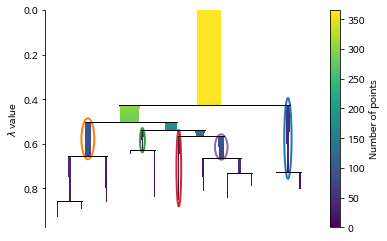

In [24]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)
clusterer.fit(tsne_df)

# 클러스터를 몇개로 하면 좋을지 알려줌
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.show()

In [25]:
# 모델 객체 생성
model_hds = hdbscan.HDBSCAN(min_cluster_size=8).fit(tsne_df)

# 예측 데이터 생성
pred_hds = model_hds.fit_predict(tsne_df)

# 데이터 프레임 만들기
df3 = pd.DataFrame(tsne_df)
df3["labels"] = pred_hds

print(np.unique(df3["labels"]), len(df3))
df3.tail(2)

[-1  0  1  2  3  4] 366


,x,y,labels
글램핑다,7.901423,-7.311056,4
냉장고,4.432961,18.810879,1


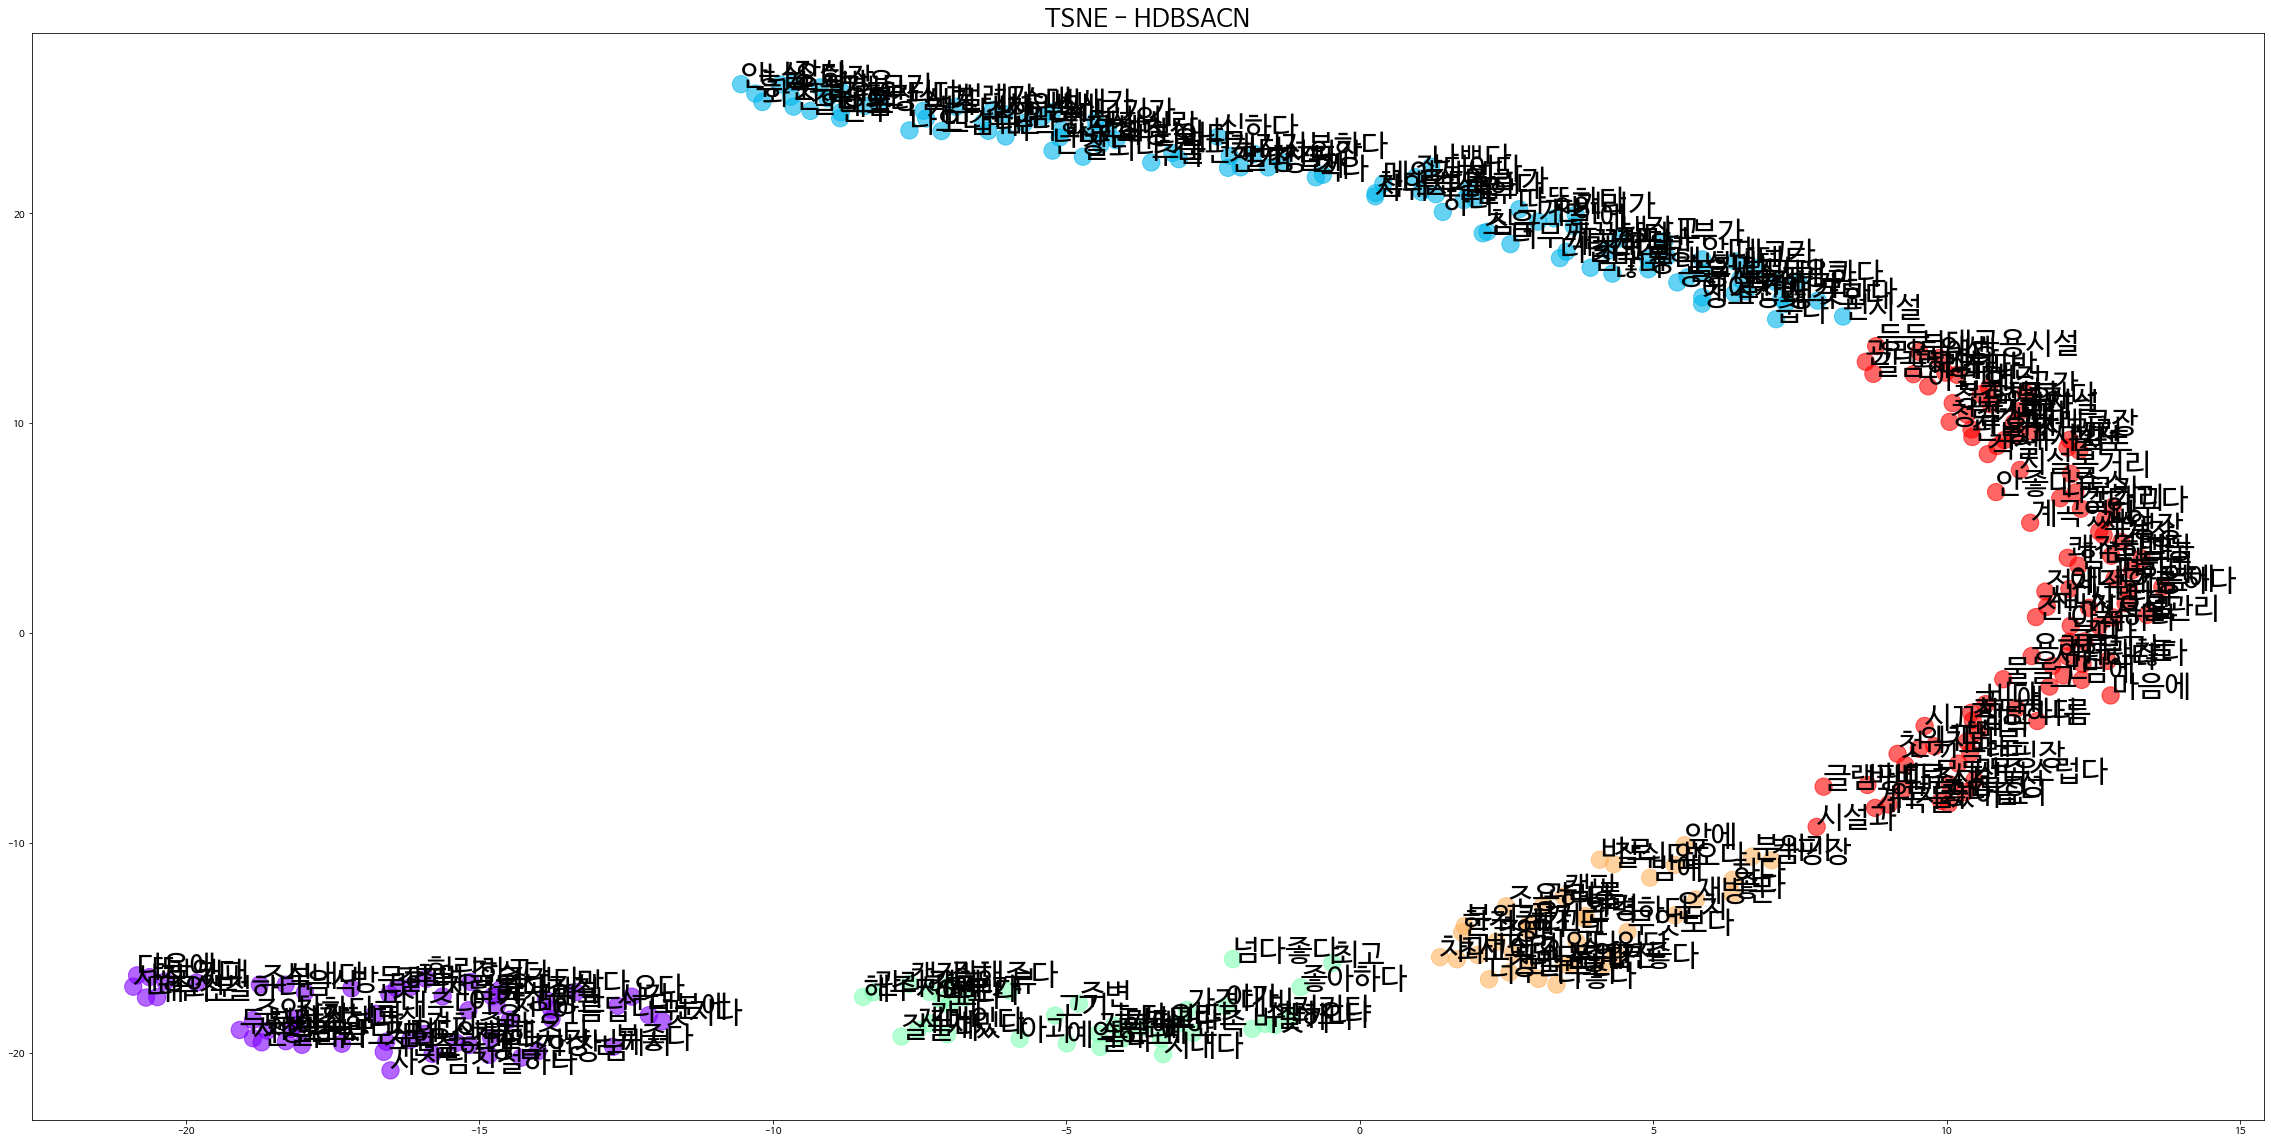

In [26]:
plt.figure(figsize=(40, 20))
plt.title("TSNE - HDBSACN", fontsize= 25)
df3.drop(df3[df3['labels']== -1].index,inplace=True)
plt.scatter(df3["x"], df3["y"], c= df3["labels"], s=300, cmap="rainbow", alpha=0.6)
    
for i, v in enumerate(df3.index):
    plt.annotate(v, xy=(df3["x"][i], df3["y"][i]), fontsize=30)

plt.show()

In [27]:
for idx in np.unique(df3["labels"]):
    print(f"Group{idx}\n",df3[df3["labels"]==idx].index.tolist())

Group0
 ['서비스', '친절하다', '사장님', '전망', '가격', '직원분', '오다', '음식조식', '친절', '또', '사장님께서', '주인분', '다음에', '분', '맛있다', '너무친절하다', '사모님', '직원', '저렴하다', '내외분', '경치좋다', '즐겁다', '사장님친절하다', '가성비', '보내다', '시간', '주인', '뷰좋다', '멋지다', '음식', '경관', '사장님과', '착하다', '조식', '사장', '힐링하고', '끝내주다', '방문하다', '갈다', '잘쉬다', '부부', '아름답다', '맛', '만다', '추억', '덕분에', '두분', '친절하다심', '절하다', '커피', '장님', '다다', '야경', '주인장님', '안내해주다']
Group1
 ['메인시설', '깨끗하다', '청결', '화장실', '많다', '없다', '샤워실', '개수대', '샤워장', '넓다', '방', '비품', '따뜻하다', '않다', '관리가', '불편하다', '내부', '잘되어다', '편시설', '벌레', '물', '온수', '많', '벌레가', '생각보다', '나오다', '멀다', '안되다', '잘되다', '잘나오다', '샤워시설', '깨끗', '난방', '불', '바닥', '좁다', '화장실과', '작다', '부족하다', '심하다', '침구', '에어컨', '냄새', '데크', '냄새가', '모기', '놀거리', '개수대가', '소음', '실내', '거리가', '깨', '침대', '온수가', '안', '모기가', '나쁘다', '식기', '안나오다', '방음', '놀거리가', '텐트', '수압', '춥다', '샤워', '전기장판', '침구류', '내부가', '화장실랑', '거', '추다', '화', '안에', '하나', '약하다', '개별', '실', '화장', '공용시설', '사용하다', '지저분하다', '화장실나', '더럽다', '상태', '못하다', '전혀', '데크가', '휴지', '장실', '개', '너무깨끗하다